正在读取 JSON 文件，来源目录: d:\ComputerScience\VscodeProject\Teacher-Analysis\NUIST_teacher_data

已处理 171 个 JSON 文件。

准备绘制前 40 名教师的点赞数条形图...


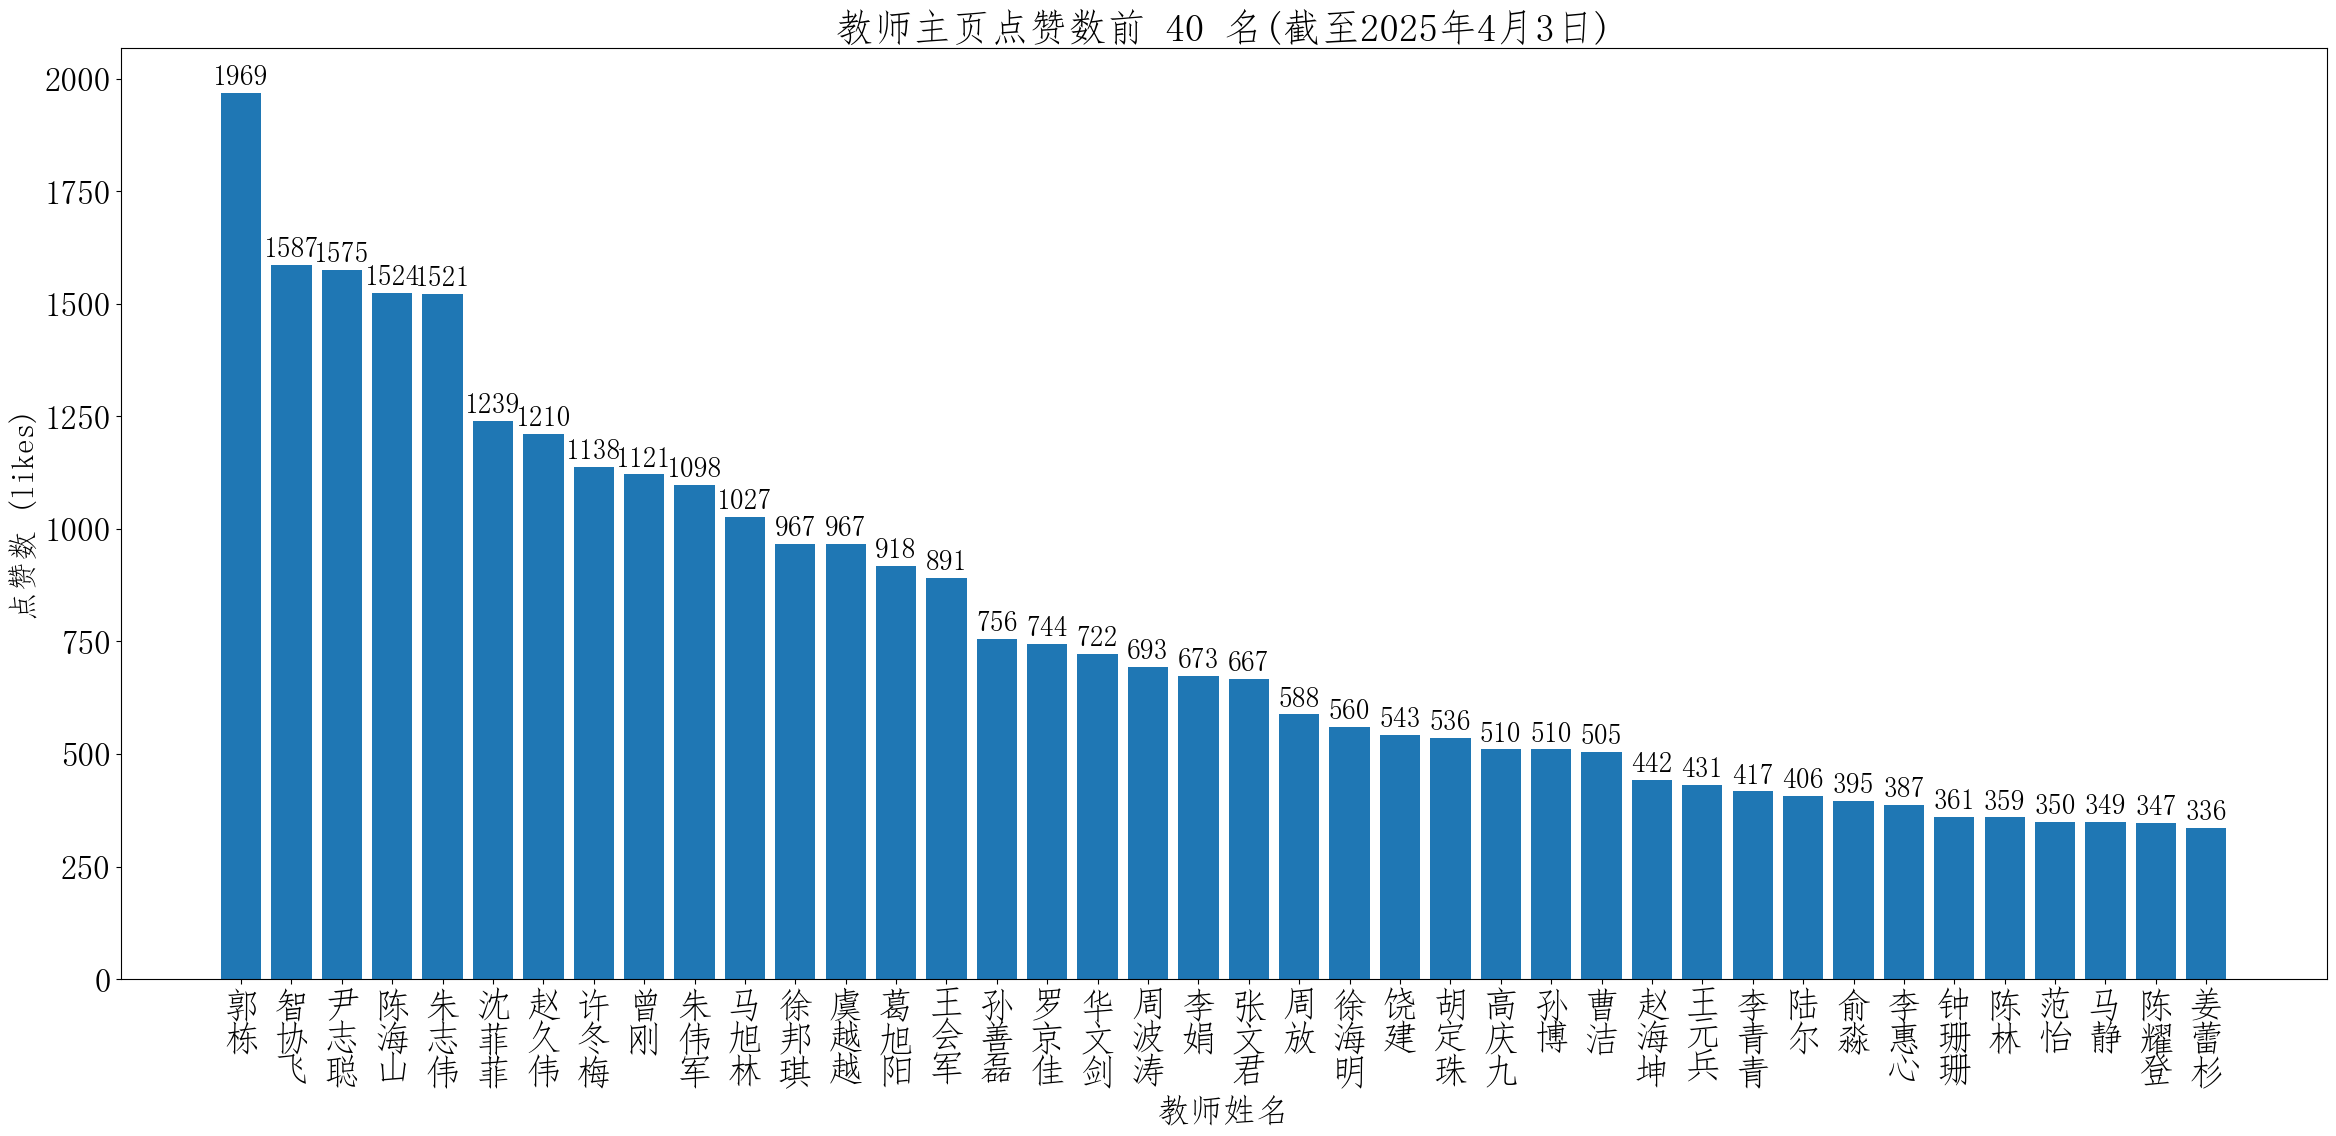

In [39]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 配置区 ---
data_directory = 'NUIST_teacher_data'
top_n = 40
# --- 配置区结束 ---

results = []

# --- 读取数据  ---
print(f"正在读取 JSON 文件，来源目录: {os.path.abspath(data_directory)}")
for filename in os.listdir(data_directory):
    if filename.endswith('.json'):
        teacher_name = os.path.splitext(filename)[0]
        file_path = os.path.join(data_directory, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        likes_value = data.get('likes', None) if isinstance(data, dict) else None
        results.append({'teacher': teacher_name, 'likes': likes_value})

print(f"\n已处理 {len(results)} 个 JSON 文件。")

# --- 数据处理 (核心逻辑) ---
if results:
    df = pd.DataFrame(results)
    df['likes_numeric'] = pd.to_numeric(df['likes'], errors='coerce')
    df_numeric = df.dropna(subset=['likes_numeric'])
    df_numeric['likes_numeric'] = df_numeric['likes_numeric'].astype(int)
    df_sorted = df_numeric.sort_values(by='likes_numeric', ascending=False)
    df_top = df_sorted.head(top_n)

    # --- 绘图 ---
    if not df_top.empty:
        print(f"\n准备绘制前 {top_n} 名教师的点赞数条形图...")

        # --- 配置字体 ---
        plt.rcParams['font.sans-serif'] = ["FangSong"]
        plt.rcParams['axes.unicode_minus'] = False

        # --- 开始绘图 ---
        plt.figure(figsize=(24, 12))

        bars = plt.bar(df_top['teacher'], df_top['likes_numeric'])

        # --- 设置标题和标签，显著增大字号 ---
        plt.title(f'教师主页点赞数前 {top_n} 名(截至2025年4月3日)', fontsize=28)  # 大标题
        plt.ylabel('点赞数 (likes)', fontsize=22)           # Y轴标签
        plt.xlabel('教师姓名', fontsize=24)               # X轴标签 (恢复显示)

        # --- 处理竖排文字刻度标签，并增大字号 ---
        vertical_labels = ['\n'.join(list(name)) for name in df_top['teacher']]

        plt.xticks(
            ticks=range(len(df_top['teacher'])),
            labels=vertical_labels,
            fontsize=26,        # 显著增大刻度字号
            linespacing=1.0     # 可以调整行间距
        )

        # --- 增大 Y 轴刻度字号 ---
        plt.yticks(fontsize=24)

        # --- 在条形图顶部显示加粗数值，并增大字号 ---
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.0,
                yval + 10,          # 增加偏移量，避免与条形重叠
                int(yval),
                va='bottom',
                ha='center',
                fontsize=20,        # 增大数值字号
                fontweight='bold'
            )

        # 调整布局以适应更大的字体和标签
        plt.tight_layout(pad=3.0) # 增加更多 padding

        # 显示图形
        plt.show()

    else:
        print("\n没有找到有效的教师点赞数据用于绘图。")
else:
    print("\n未能加载任何数据，无法进行分析。")

正在读取 JSON 文件并提取出生年份，来源目录: d:\ComputerScience\VscodeProject\Teacher-Analysis\NUIST_teacher_data

已处理 171 位教师的原始出生年份数据。

--- 各年龄层级（5年）教师人数统计 ---
age_group
95后    11
90后    22
85后    37
80后    34
75后    19
70后    15
65后     9
60后    11
60前     1
未知     12
Name: count, dtype: int64

注意：有 12 位教师的出生年份未知或无法解析。

准备绘制各年龄层级（5年）教师人数分布图...
找到字体 'FangSong'，将用于显示中文。


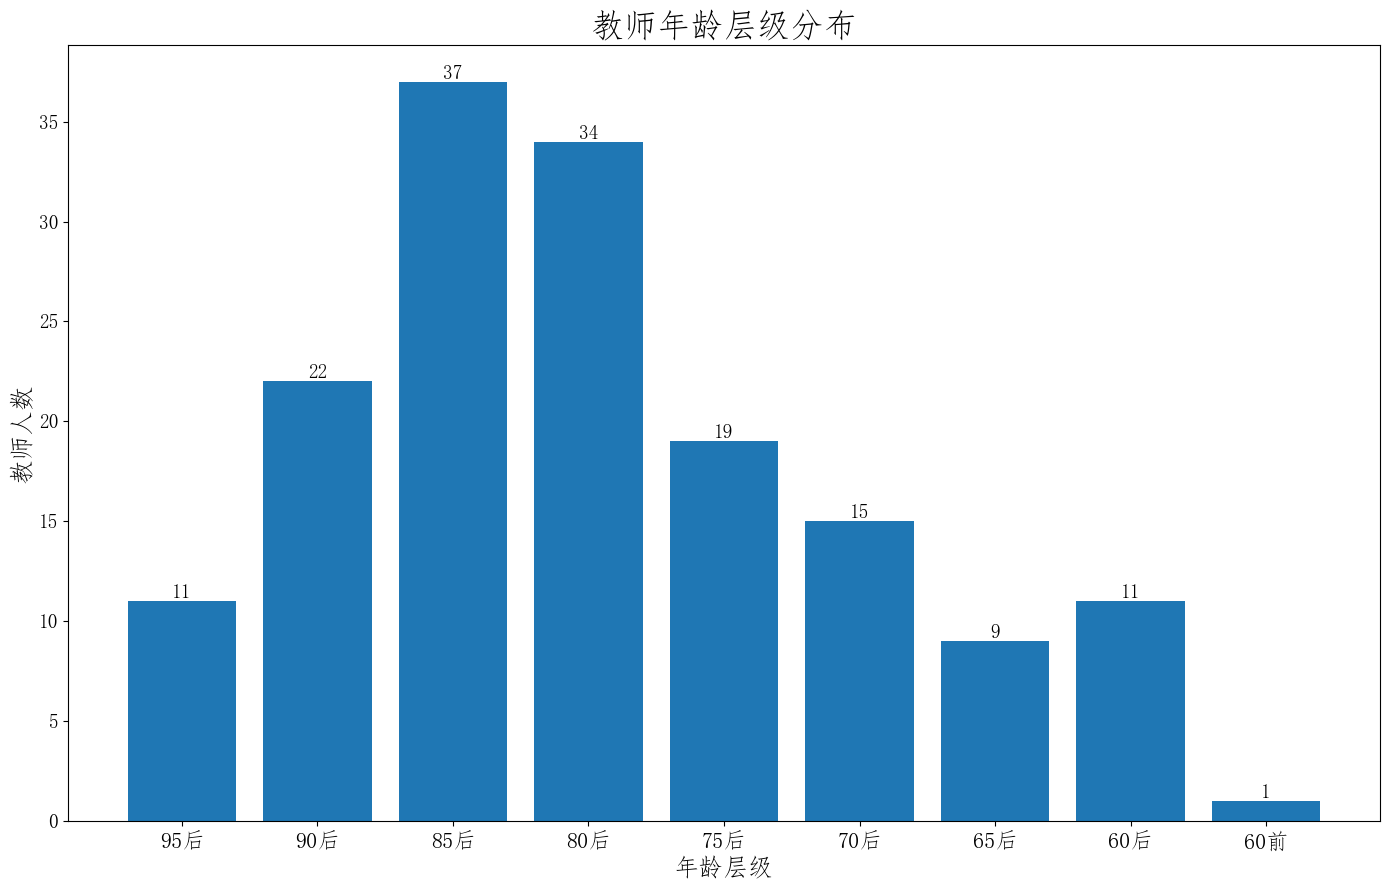

In [37]:
import os
import json
import re 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np 

# --- 配置区 ---
data_directory = 'NUIST_teacher_data' 
# 新的分组顺序 (从新到旧)
group_order = ["95后", "90后", "85后", "80后", "75后", "70后", "65后", "60后", "60前", "未知"]
# --- 配置区结束 ---

birth_years = []

# --- 读取和提取出生年份 (与之前相同) ---
print(f"正在读取 JSON 文件并提取出生年份，来源目录: {os.path.abspath(data_directory)}")
for filename in os.listdir(data_directory):
    if filename.endswith('.json'):
        teacher_name = os.path.splitext(filename)[0]
        file_path = os.path.join(data_directory, filename)
        birth_year_value = None
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            bio_details = data.get('bio_details', {}) if isinstance(data, dict) else {}
            birth_year_value = bio_details.get('birth_year', None) if isinstance(bio_details, dict) else None
            birth_years.append({'teacher': teacher_name, 'raw_birth_year': birth_year_value})
        except Exception as e:
            print(f"警告：处理文件 {filename} 时出错: {e}")
            birth_years.append({'teacher': teacher_name, 'raw_birth_year': None})

print(f"\n已处理 {len(birth_years)} 位教师的原始出生年份数据。")

# --- 清洗年份并按5年分组 ---
if birth_years:
    df = pd.DataFrame(birth_years)

    # 清洗 birth_year 列 (与之前相同)
    def clean_birth_year(year_val):
        if year_val is None: return np.nan
        if isinstance(year_val, (int, float)): return int(year_val)
        if isinstance(year_val, str):
            match = re.search(r'(\d{4})', year_val)
            if match:
                try: return int(match.group(1))
                except ValueError: return np.nan
        return np.nan

    df['cleaned_year'] = df['raw_birth_year'].apply(clean_birth_year)

    # --- 定义新的 5 年分组函数 ---
    def get_5year_group(year):
        if pd.isna(year): return "未知"
        year = int(year)
        # 不再包含 00 后
        if year >= 1995 and year <= 1999: return "95后"
        elif year >= 1990 and year <= 1994: return "90后"
        elif year >= 1985 and year <= 1989: return "85后"
        elif year >= 1980 and year <= 1984: return "80后"
        elif year >= 1975 and year <= 1979: return "75后"
        elif year >= 1970 and year <= 1974: return "70后"
        elif year >= 1965 and year <= 1969: return "65后"
        elif year >= 1960 and year <= 1964: return "60后"
        elif year < 1960 and year > 1900: return "60前" # 1960年之前的归为一组
        else: return "未知" # 处理无效或超出预期范围的年份

    df['age_group'] = df['cleaned_year'].apply(get_5year_group)

    # --- 统计各分组人数 ---
    group_counts = df['age_group'].value_counts()
    
    # 按照预定义的顺序对结果进行排序，填充缺失的年代为 0
    group_counts_ordered = group_counts.reindex(group_order, fill_value=0)

    print("\n--- 各年龄层级（5年）教师人数统计 ---")
    print(group_counts_ordered)
    
    unknown_count = group_counts_ordered.get("未知", 0)
    if unknown_count > 0:
        print(f"\n注意：有 {unknown_count} 位教师的出生年份未知或无法解析。")

    # --- 绘图 ---
    if not group_counts_ordered.empty:
        print(f"\n准备绘制各年龄层级（5年）教师人数分布图...")

        # --- 配置字体 (与之前相同) ---
        zh_font_name = None
        font_preferences = ['FangSong', 'SimHei', 'Microsoft YaHei', 'PingFang SC', 'Source Han Sans CN']
        for font_name in font_preferences:
            try:
                fm.findfont(font_name)
                zh_font_name = font_name
                print(f"找到字体 '{zh_font_name}'，将用于显示中文。")
                break
            except:
                print(f"未找到字体 '{font_name}'...")
                continue
        if zh_font_name:
            plt.rcParams['font.sans-serif'] = [zh_font_name]
        else:
            print("警告：未能找到指定的任何中文字体。")
        plt.rcParams['axes.unicode_minus'] = False

        # --- 开始绘图 ---
        plt.figure(figsize=(14, 9)) # 可以调整尺寸
        
        # 过滤掉 "未知" 类别进行绘图
        plot_data = group_counts_ordered.drop("未知", errors='ignore') 
        
        bars = plt.bar(plot_data.index, plot_data.values)

        # --- 设置标题和标签，使用较大字号 ---
        plt.title('教师年龄层级分布', fontsize=24)
        plt.ylabel('教师人数', fontsize=18)
        plt.xlabel('年龄层级', fontsize=18)

        # --- 设置 X, Y 轴刻度字号 ---
        plt.xticks(fontsize=16) # X轴刻度使用分组标签
        plt.yticks(fontsize=14)

        # --- 在条形图顶部显示加粗数值 ---
        for bar in bars:
            yval = bar.get_height()
            if yval > 0:
                plt.text(
                    bar.get_x() + bar.get_width()/2.0,
                    yval,
                    int(yval),
                    va='bottom',
                    ha='center',
                    fontsize=14,
                    fontweight='bold'
                )

        plt.tight_layout()
        plt.show()

    else:
        print("\n没有找到有效的教师年龄数据用于绘图。")
else:
    print("\n未能加载任何数据，无法进行分析。")